# Redes Neuronales

Como es una neurona?

<div style="text-align:center">
<img src="https://raw.githubusercontent.com/amiune/freecodingtour/main/cursos/espanol/deeplearning/img/neurona.png" width="500"/>
</div>

Como la podemos describir matematicamente?

- Las dentritas son las variables de entrada
- El cuerpo celular es una funcion de suma
- Si la suma es mayor a un umbral se activa el axon (funcion de activacion)
- El axon es la variable de salida

<div style="text-align:center">
<img src="https://raw.githubusercontent.com/amiune/freecodingtour/main/cursos/espanol/deeplearning/img/neurona_matematica.png" width="700"/>
</div>

Si vemos este modelo de cerca vemos que el modelo matematico una neurona es igual a una regresion lineal o logistica dependiendo de su funcion de activacion. O sea es una caja negra que puede predecir nuevos datos a partir de una tabla de entrenamiento.

## Recordemos como funciona la regresion logistica

En este ejemplo intentaremos adivinar cuantos likes tiene un video de tiktok a partir de la cantidad de vistas

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
# tiktok vistas y likes de distintos videos

views = [234_000, 8_000, 217_000, 25_000, 62_000, 107_000, 
         140_000, 191_000, 189_000, 496_000, 221_000, 238_000]
likes = [ 39_000,   362,  31_000,  1_500,  4_000,   5_000,   
           6_000,  15_000,  11_000,  30_000,  30_000,  31_000]

In [18]:
df = pd.DataFrame({"Views":views,"Likes":likes})

In [19]:
df.head()

,Views,Likes
0,234000,39000
1,8000,362
2,217000,31000
3,25000,1500
4,62000,4000


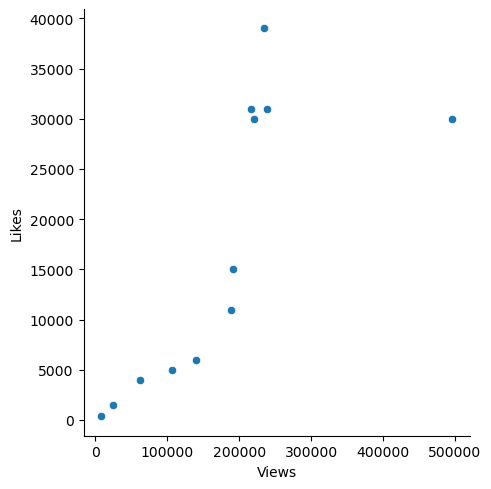

In [20]:
sns.relplot(x="Views",y="Likes", data=df);

### IA: adivinar y luego minimzar el error repetidamente

Otra forma de obtener dicha linea es a traves del algoritmo de gradiente descendiente. Este algorimo es muy importante en inteligencia artificial ya que nos permite encontrar un minimo de forma iterativa.

#### Generamos lineas al azar

Empezamos generando lineas al azar para ver que tan buenas predictoras son. Para ello calculamos la suma de las distancias de los puntos de la tabla de entrenamiento a las distintas rectas.

In [21]:
#inicializo con valores aleatorios
b = 0.0
w = 0.1
#hago mi prediccion
def prediccion(x, w, b): 
    return w * x + b
#mi suma de los errores al cuadrado sera
def costo(x, w, b, y): 
    return np.sum((y - prediccion(x,w,b))**2)

Solo elegiremos la pendiente w al azar, la ordenada al origen b la dejaremos fija en cero para que el ejemplo sea mas simple:

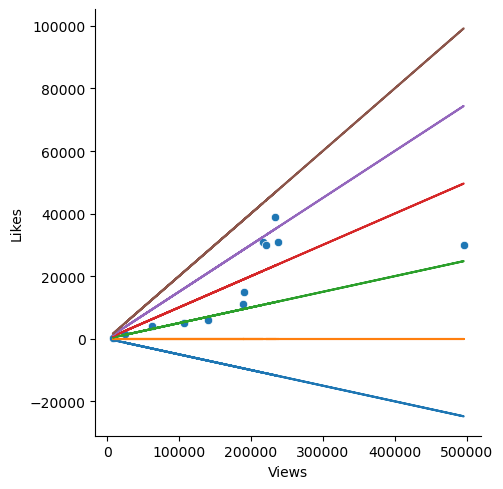

In [22]:
sns.relplot(x="Views",y="Likes", data=df)
pendientes = [-0.05,0.0,0.05,0.1,0.15,0.2]
costos = []
for w in pendientes:
    costos.append(costo(df["Views"], w, b, df["Likes"]))
    plt.plot(df["Views"], prediccion(df["Views"], w, b), '-');

#### Calculamos los errores de cada linea que creamos

Elegido un w al azar podemos calcular su costo, es decir, la suma de diferencias al cuadrado de los puntos de la tabla de entrenamiento a la linea dada por w. 

In [23]:
#tabla de la suma de errores para cada linea
df_costos = pd.DataFrame({"w":pendientes,"costo":costos})
df_costos

,w,costo
0,-0.05,1.220605e+10
1,0.00,5.668381e+09
2,0.05,1.936366e+09
3,0.10,1.010002e+09
4,0.15,2.889287e+09
5,0.20,7.574223e+09


Esta tabla nos da el costo de cada linea dependiendo de la pendiente w elegida. Si extendemos esta tabla para todos los w obtenemos la llamada funcion de costo:

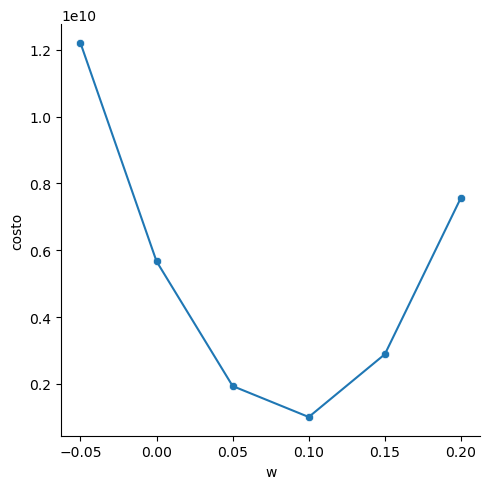

In [24]:
sns.relplot(x="w",y="costo", data=df_costos);
plt.plot(pendientes, costos, '-');

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


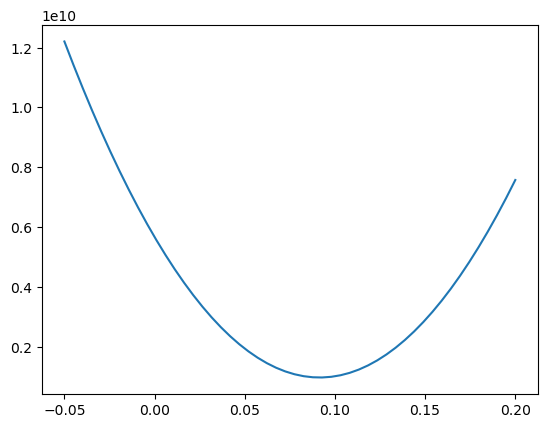

In [25]:
from scipy.interpolate import make_interp_spline, BSpline
xnew = np.linspace(np.min(pendientes), np.max(pendientes), 50) 
spl = make_interp_spline(pendientes, costos, k=3)
plt.plot(xnew, spl(xnew));

#### El truco matematico del gradiente descendiente

Teniendo la funcion de costo podemos utilizar la pendiente (derivada) de dicha funcion de costo para saber en que direccion tenemos que buscar para encontrar el minimo:

In [26]:
#utilizamos la libreria sympy para obtener la derivada de la funcion de costo
import sympy as sy

In [27]:
x,y,w,b = sy.symbols('x y w b')
costFunf = (y-(w*x+b))**2
costFunf

(-b - w*x + y)**2

Derivada parcial de la funcion de costo respecto de w:

In [28]:
sy.diff(costFunf,w)

-2*x*(-b - w*x + y)

Derivada parcial de la funcion de costo respecto de b:

In [29]:
sy.diff(costFunf,b)

2*b + 2*w*x - 2*y

In [30]:
del x,y,w,b

Las siguientes funciones nos indican entonces en que direccion tenemos que ir para encontrar el minimo:

In [31]:
def gradW(x,y,w,b):
    grad = -2*x*(-b-w*x+y)
    grad = np.sum(grad)
    return grad

In [32]:
def gradb(x,y,w,b):
    grad = 2*b+2*w*x-2*y
    grad = np.sum(grad)
    return grad

#### El algortimo del gradiente descendiente

A continuacion empiezo con un w al azar y luego lo voy modificando de a poco para ir en direccion hacia el minimo costo. Tengo que tener cuidado de ir modificando de a poco porque si el paso que doy es demasiado grande el algoritmo puede diverger (no encontrara el minimo) o puede tardar mucho si el paso es muy pequeño. A el tamaño de cada paso hacia el minimo se lo conoce como Learning Rate (LR)

In [33]:
x = np.array(df["Views"])
y = np.array(df["Likes"])
w = 0.2
b = 0.0
ws, cs = [], []
for i in range(20):
    ws.append(w)
    cost = costo(x, w, b, y)
    cs.append(cost)
    grad = gradW(x, y, w, b)
    print(f"w:{w:0.3f} cost:{int(cost):10}")
    w = w - 0.0000000000003 * grad #LR adecuado. El algoritmo encuentra el minimo
    #w = w - 0.0000000000018 * grad #LR demasiado grande. El algoritmo diverge
    #w = w - 0.00000000000001 * grad #LR demasiado chico. El algoritmo tarda mucho

w:0.200 cost:7574222644
w:0.163 cost:3875577341
w:0.139 cost:2248187923
w:0.123 cost:1532142966
w:0.113 cost:1217085994
w:0.105 cost:1078462163
w:0.101 cost:1017468221
w:0.098 cost: 990631126
w:0.096 cost: 978822910
w:0.094 cost: 973627341
w:0.093 cost: 971341311
w:0.093 cost: 970335467
w:0.092 cost: 969892899
w:0.092 cost: 969698172
w:0.092 cost: 969612492
w:0.092 cost: 969574793
w:0.092 cost: 969558206
w:0.092 cost: 969550908
w:0.092 cost: 969547697
w:0.092 cost: 969546284


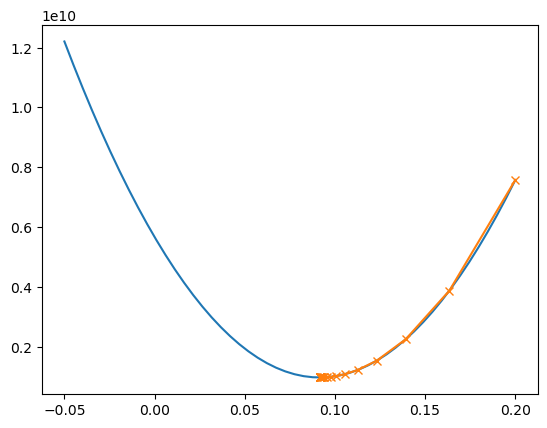

In [34]:
from scipy.interpolate import make_interp_spline, BSpline
xnew = np.linspace(np.min(pendientes), np.max(pendientes), 50) 
spl = make_interp_spline(pendientes, costos, k=3)
plt.plot(xnew, spl(xnew));
plt.plot(ws, cs, 'x-');

#### Distintos Learning Rates

In [35]:
x = np.array(df["Views"])
y = np.array(df["Likes"])
w = 0.2
b = 0.0
ws, cs = [], []
for i in range(20):
    ws.append(w)
    cost = costo(x, w, b, y)
    cs.append(cost)
    grad = gradW(x, y, w, b)
    print(f"w:{w:0.3f} cost:{int(cost):10}")
    #w = w - 0.0000000000003 * grad #LR adecuado. El algoritmo encuentra el minimo
    w = w - 0.0000000000018 * grad #LR demasiado grande. El algoritmo diverge
    #w = w - 0.00000000000001 * grad #LR demasiado chico. El algoritmo tarda mucho

w:0.200 cost:7574222644
w:-0.019 cost:7841967845
w:0.204 cost:8120567095
w:-0.024 cost:8410460403
w:0.209 cost:8712105617
w:-0.028 cost:9025979142
w:0.214 cost:9352576701
w:-0.033 cost:9692414107
w:0.219 cost:10046028089
w:-0.038 cost:10413977130
w:0.224 cost:10796842357
w:-0.043 cost:11195228451
w:0.229 cost:11609764609
w:-0.049 cost:12041105535
w:0.235 cost:12489932472
w:-0.055 cost:12956954280
w:0.241 cost:13442908557
w:-0.061 cost:13948562800
w:0.247 cost:14474715621
w:-0.067 cost:15022198007


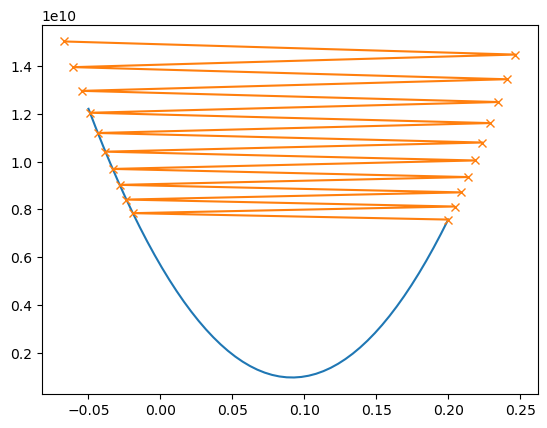

In [36]:
from scipy.interpolate import make_interp_spline, BSpline
xnew = np.linspace(np.min(pendientes), np.max(pendientes), 50) 
spl = make_interp_spline(pendientes, costos, k=3)
plt.plot(xnew, spl(xnew));
plt.plot(ws, cs, 'x-');

In [37]:
x = np.array(df["Views"])
y = np.array(df["Likes"])
w = 0.2
b = 0.0
ws, cs = [], []
for i in range(20):
    ws.append(w)
    cost = costo(x, w, b, y)
    cs.append(cost)
    grad = gradW(x, y, w, b)
    print(f"w:{w:0.3f} cost:{int(cost):10}")
    #w = w - 0.0000000000003 * grad #LR adecuado. El algoritmo encuentra el minimo
    #w = w - 0.0000000000018 * grad #LR demasiado grande. El algoritmo diverge
    w = w - 0.00000000000001 * grad #LR demasiado chico. El algoritmo tarda mucho

w:0.200 cost:7574222644
w:0.199 cost:7426811174
w:0.198 cost:7282689819
w:0.196 cost:7141785145
w:0.195 cost:7004025358
w:0.194 cost:6869340267
w:0.193 cost:6737661246
w:0.192 cost:6608921202
w:0.191 cost:6483054541
w:0.190 cost:6359997129
w:0.188 cost:6239686266
w:0.187 cost:6122060653
w:0.186 cost:6007060355
w:0.185 cost:5894626778
w:0.184 cost:5784702634
w:0.183 cost:5677231915
w:0.182 cost:5572159863
w:0.181 cost:5469432940
w:0.180 cost:5368998805
w:0.179 cost:5270806286


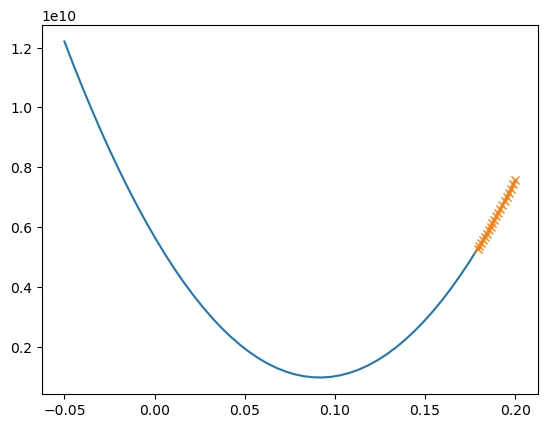

In [38]:
from scipy.interpolate import make_interp_spline, BSpline
xnew = np.linspace(np.min(pendientes), np.max(pendientes), 50) 
spl = make_interp_spline(pendientes, costos, k=3)
plt.plot(xnew, spl(xnew));
plt.plot(ws, cs, 'x-');

#### Extendemos el algoritmo para mas dimensiones

Aqui extendemos el algoritmo para encontrar tambien la ordenada al origen. De la misma forma podemos extenderlo para mas dimensiones.

In [39]:
x = np.array(df["Views"])
y = np.array(df["Likes"])
w = 0.2
b = 0.0
for epoch in range(60):
    cost = costo(x, w, b, y)
    tmp_gradW = gradW(x, y, w, b)
    tmp_gradb = gradb(x, y, w, b)
    if epoch%5 == 0: print(f"w:{w:0.4f} b:{int(b):4} cost:{int(cost):10}")
    w = w - 0.000000000001 * tmp_gradW
    b = b - 0.03 * tmp_gradb

w:0.2000 b:   0 cost:7574222644
w:0.0936 b:-3824 cost:1182882644
w:0.0932 b: 485 cost: 968780228
w:0.0863 b:1423 cost: 951531737
w:0.0844 b:1958 cost: 948898121
w:0.0834 b:2165 cost: 948432137
w:0.0830 b:2256 cost: 948347957
w:0.0828 b:2294 cost: 948332709
w:0.0828 b:2311 cost: 948329947
w:0.0827 b:2318 cost: 948329446
w:0.0827 b:2321 cost: 948329355
w:0.0827 b:2322 cost: 948329339


## Redes Neuronales

El siguiente paso obvio es conectar varias neuronas para lograr una red neuronal:

<div style="text-align:center">
<img src="../img/red_neuronal.png" width="700"/>
</div>

En esta pequeña red tenemos una sola capa oculta pero podriamos tener todas las que querramos. Cada circulo de nuestra capa oculta y de la capa de salida es un una neurona.

Con esta idea se penso que se iba a lograr igualar la inteligencia humana pero los resultados no eran mejores que los de las otras cajas negras que vimos en el [Curso de Ciencia de datos](https://www.freecodingtour.com/cursos/espanol/datascience/datascience.html). Esto se debe a muchos motivos pero es interesante pensar en que nosotros no tenemos sensores electronicos que manden numeros en forma de tabla a nuestro cerebro. Mayormente aprendemos a traves de la vision y de la lectura y aqui fue que con numerosas modificaciones a estas arquitecturas de redes neuronales se consiguio que puedan servir para hacer predicciones de imagenes y texto mucho mejor que cualquier otra caja negra antes conocida. En las proximas unidades veremos como se llego a esto.

### Como implementar aqui el algoritmos del gradiente descendiente?

En una red neuronal es mas complejo implementar el algoritmo del gradiente descendiente debido a que hay muchos mas pesos a ajustar y que cada uno influye de manera diferente en el resultado. El truco para lograr que el gradiente descendiente es utilizar la regla de la cadena para ir calculando la influencia de cada peso en la salida.

El proceso es complejo pero el siguiente video de [Daniel Smilkov](https://smilkov.com/) lo muestra muy bien y en detalle.

<video witdth="640"
       controls
       src="https://raw.githubusercontent.com/amiune/freecodingtour/main/cursos/espanol/deeplearning/videos/Backpropagation.mp4">
</video>

Otros recursos muy buenos para entender el proceso matematico que ocurre dentro de una red neuronal aqui dejos dos recursos muy buenos:
- [Multiplication in Neural Networks](https://datascience.stackexchange.com/questions/75855/what-types-of-matrix-multiplication-are-used-in-machine-learning-when-are-they)
- [The Math behind Neural Networks - Backpropagation](https://www.jasonosajima.com/backprop)

Tambien en la siguiente unidad lo podremos ver paso a paso con la utilizacion de grafos de computacion y autogradiente.

# Fin: [Volver al contenido del curso](https://www.freecodingtour.com/cursos/espanol/deeplearning/deeplearning.html)

Referencias de las imagenes:

- Neurona: https://en.wikipedia.org/wiki/Neuron#/media/File:Blausen_0657_MultipolarNeuron.png

Otros recursos interesantes:
- [Guia para Ingenieros sobre Redes Neuronales](https://www.interdb.jp/dl/)
- [Operaciones matriciales de redes neuronales a mano](https://aibyhand.substack.com/t/advanced)

Arquitecturas:
- [Convolucional](https://colab.research.google.com/github/amiune/freecodingtour/blob/main/cursos/espanol/deeplearning/nn_architectures/E2_Convolutional_Arch.ipynb)
- [Autoencoders](https://colab.research.google.com/github/amiune/freecodingtour/blob/main/cursos/espanol/deeplearning/nn_architectures/E3_Autoencoders_Arch.ipynb)
- [Diffusers](https://colab.research.google.com/github/amiune/freecodingtour/blob/main/cursos/espanol/deeplearning/nn_architectures/E4_Diffusers_Arch.ipynb)
- [Transformer](https://colab.research.google.com/github/amiune/freecodingtour/blob/main/cursos/espanol/deeplearning/nn_architectures/E5_Transformers_Arch.ipynb)
- [AlphaFold](https://elanapearl.github.io/blog/2024/the-illustrated-alphafold/)